In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from matplotlib import pyplot as plt

import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier
from scipy.special import expit as sigmoid
from helpers import plot_losses

## Higgs Boson Dataset

In [4]:
def run_logistic(A, y, param):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y, logging=True)
    print('{0} - score: {1:.4f}'.format(param, m.score(A, y)))
    return list_losses, np.arange(0.0, len(list_losses)) * m.compute_loss_every

In [5]:
def load_csv_data(data_path):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    return yb, input_data

In [6]:
def clean(input_data, mean=False):

    #Replace -999 by most frequent value of column
    for i in range(input_data.shape[1]):
        current_col = input_data[:, i]

        if -999.0 in current_col:
            indices_to_change = (current_col == -999.0)
            if mean:
                curr_mean = np.mean(current_col[~indices_to_change])
                current_col[indices_to_change] = curr_mean
            else:
                (values,counts) = np.unique(current_col[~indices_to_change], return_counts=True)
                ind=np.argmax(counts)
                current_col[indices_to_change] = values[ind] if len(values) > 0 else 0

    return input_data

In [7]:
def standardize(x):
    """Standardize the given data"""
    means = x.mean(0)
    stds = x.std(0)
    return (x - means)/stds

### Load dataset

In [8]:
y, A = load_csv_data('train.csv')
A = standardize(clean(A, True))
y = 1 *(y > 0.0)

### Compute the baseline with SGD classifier 

In [9]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.745812
Final loss: 0.5064191793315126


### Computing with Decentralized SGD

In [10]:
def cycle_rw(p, n_cores):
    q = 1-p

    W = np.zeros(shape=(n_cores, n_cores))
    np.fill_diagonal(W[1:], q, wrap=False)
    np.fill_diagonal(W[:, 1:], p, wrap=False)
    W[0, n_cores - 1] = q
    W[n_cores - 1, 0] = p
    return W

In [11]:
def cycle_lazy_rw(lazy_p, p, n_cores):
    if lazy_p + p > 1:
        raise ValueError('Wrong proba')
    q = 1-p - lazy_p

    W = np.zeros(shape=(n_cores, n_cores))
    np.fill_diagonal(W, lazy_p, wrap=False)
    np.fill_diagonal(W[1:], q, wrap=False)
    np.fill_diagonal(W[:, 1:], p, wrap=False)
    W[0, n_cores - 1] = q
    W[n_cores - 1, 0] = p
    return W

In [12]:
def spectral_gap(W):
    eigs = np.linalg.eigvals(W)
    max_eig = np.sort(np.abs(eigs))[-2]
    return 1 - max_eig

### Comparison Unbalanced Ring with no self-loops VS Unbalanced Ring with self-loops

In [14]:
reg = 1 / A.shape[0]
n_features = A.shape[1]

params_cyle_rw = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, tau=n_features, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_rw(0.7, 255),
                           data_distribution_random_seed=2,
                           data_distribution_strategy='naive', tol=1e-6, compute_loss_every=5)

list_losses_rw, list_iterations_rw = run_logistic(A, y, params_cyle_rw)

params_cyle_lazy_rw = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, tau=n_features, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_lazy_rw(0.3, 0.6, 255),
                           data_distribution_random_seed=2,
                           data_distribution_strategy='naive', tol=1e-6, compute_loss_every=5)

list_losses_lazy_rw, list_iterations_lazy_rw = run_logistic(A, y, params_cyle_lazy_rw)

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [980/980]      24s       5.9997    0.6834        
[2/5]      [980/980]      49s       7.9555    0.6837        
[3/5]      [980/980]      74s       8.6957    0.6841        
[4/5]      [980/980]      99s       9.0295    0.6851        
[5/5]      [980/980]      124s      9.1662    0.6866        
{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.1, 'tau': 30, 'regularizer': 4e-06, 'quantization_method': 'full', 'n_machines': 255, 'communication_method': 'plain', 'topology': array([[0. , 0.7, 0. , ..., 0. , 0. , 0.3],
       [0.3, 0. , 0.7, ..., 0. , 0. , 0. ],
       [0. , 0.3, 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0.7, 0. ],
       [0. , 0. , 0. , ..., 0.3, 0. , 0.7],
       [0.7, 0. , 0. , ..., 0. , 0.3, 0. ]]), 'data_distribution_random_seed': 2, 'data_distribution_strategy': 'naive', 'tol': 1e-06, 'compute_loss_every': 5} - score: 0.6866
Epoch      Iteration      Time      Loss 

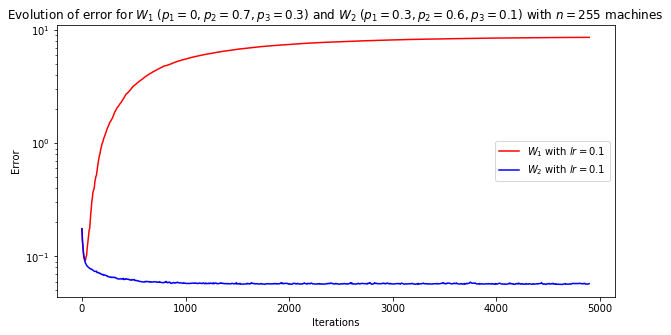

In [15]:
plt.figure(figsize=(10, 5))

plt.plot(list_iterations_rw, list_losses_rw-optimum_loss, 'r', label='$W_1$ with $lr=0.1$')
plt.plot(list_iterations_rw, list_losses_lazy_rw-optimum_loss, 'b', label='$W_2$ with $lr=0.1$')

plt.yscale('log')
plt.title('Evolution of error for $W_1 \; (p_1=0, p_2=0.7, p_3=0.3)$ and $W_2 \; (p_1=0.3, p_2=0.6, p_3=0.1)$ with $n=255$ machines')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend(loc="best")

plt.show()

### Comparison Ring with no self-loops VS Ring close to no self-loops

In [16]:
reg = 1 / A.shape[0]
n_features = A.shape[1]

params_cyle_rw_new = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, tau=n_features, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_rw(0.5, 255),
                           data_distribution_random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_rw_new, list_iterations_rw_new = run_logistic(A, y, params_cyle_rw_new)

params_cyle_lazy_rw_new = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, tau=n_features, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_lazy_rw(0.01, 0.5, 255),
                           data_distribution_random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_lazy_rw_new, list_iterations_lazy_rw_new = run_logistic(A, y, params_cyle_lazy_rw_new)

params_cyle_rw_new2 = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.01, tau=n_features, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_rw(0.5, 255),
                           data_distribution_random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_rw_new2, list_iterations_rw_new2 = run_logistic(A, y, params_cyle_rw_new2)

params_cyle_lazy_rw_new2 = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.01, tau=n_features, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_lazy_rw(0.01, 0.5, 255),
                           data_distribution_random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_lazy_rw_new2, list_iterations_lazy_rw_new2 = run_logistic(A, y, params_cyle_lazy_rw_new2)

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [980/980]      24s       6.0689    0.6832        
[2/5]      [980/980]      51s       7.8937    0.6838        
[3/5]      [980/980]      78s       8.5678    0.6850        
[4/5]      [980/980]      104s      8.8684    0.6863        
[5/5]      [980/980]      130s      8.9647    0.6888        
{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.1, 'tau': 30, 'regularizer': 4e-06, 'quantization_method': 'full', 'n_machines': 255, 'communication_method': 'plain', 'topology': array([[0. , 0.5, 0. , ..., 0. , 0. , 0.5],
       [0.5, 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0.5, 0. , 0.5],
       [0.5, 0. , 0. , ..., 0. , 0.5, 0. ]]), 'data_distribution_random_seed': 2, 'data_distribution_strategy': 'naive', 'tol': 1e-10, 'compute_loss_every': 5} - score: 0.6888
Epoch      Iteration      Time      Loss 

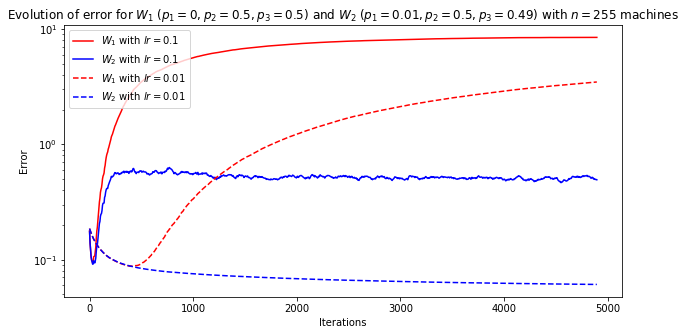

In [17]:
plt.figure(figsize=(10, 5))

plt.plot(list_iterations_lazy_rw_new2, list_losses_rw_new-optimum_loss, 'r', label='$W_1$ with $lr=0.1$')
plt.plot(list_iterations_lazy_rw_new2, list_losses_lazy_rw_new-optimum_loss, 'b', label='$W_2$ with $lr=0.1$')
plt.plot(list_iterations_lazy_rw_new2, list_losses_rw_new2-optimum_loss, 'r--', label='$W_1$ with $lr=0.01$')
plt.plot(list_iterations_lazy_rw_new2, list_losses_lazy_rw_new2-optimum_loss, 'b--', label='$W_2$ with $lr=0.01$')

plt.yscale('log')
plt.title('Evolution of error for $W_1 \; (p_1=0, p_2=0.5, p_3=0.5)$ and $W_2 \; (p_1=0.01, p_2=0.5, p_3=0.49)$ with $n=255$ machines')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend(loc="best")

plt.show()